# Solving a two-asset HANK model in sequence space

In this notebook we solve the two-asset HANK model from Auclert, Bardóczy, Rognlie, Straub (2019): "Using the Sequence-Space Jacobian to Solve and Estimate Heterogeneous-Agent Models". Please see the [Github repository](https://github.com/shade-econ/sequence-jacobian) for more information and code.

The only new concept relative to the one-asset HANK notebook is that of a **solved block**. These are extensions of simple blocks that are useful for large macro models and that's why we introduce them here, in the context of our richest model. We will apply all other concepts and tools that are familiar from other notebooks here without further explanation. 

## Model description

The household problem is characterized by the Bellman equation

$$
\begin{align} \tag{1}
V_t(e_t, b_{t-1}, a_{t-1}) = \max_{c_t, b_t, a_t} &\left\{\frac{c_t^{1-\sigma}}{1-\sigma} + \beta E_t V_{t+1}(e_{t+1}, b_t, a_t) \right\}
\\
c_t + a_t + b_t &= (1-\tau_t)w_t n_t e_t + (1 + r_t^a)a_{t-1} + (1 + r_t^b)b_{t-1} - \Psi(a_t, a_{t-1}) 
\\
a_t &\geq 0, \quad b_t \geq \underline{b},
\end{align}
$$

where the adjustment cost function is specified as

$$
\Psi(a_t, a_{t-1}) =  \frac{\chi_1}{\chi_2}\left|\frac{a_t - (1 + r_t^a) a_{t-1}}{(1 + r_{t}^a) a_{t-1} + \chi_0}\right|^{\chi_2} \left[(1 + r_t^a) a_{t-1} + \chi_0 \right],
$$

with $\chi_0, \chi_1 > 0$ and $\chi_2 > 1.$ For the full description of the model, including the problems of the other agents, please see appendix A.3 of the paper.

## 0 Import packages

The first two are standard python packages, the rest contain code we wrote for this project.

In [1]:
# Add the relative path to the top-level of the "sequence-jacobian" folder
# to be able to access the sequence_jacobian module
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt

from sequence_jacobian import simple, het, solved, create_model
from sequence_jacobian.models import two_asset

## 1 Calibrate steady state

We developed an efficient backward iteration function to solve the Bellman equation in (1). Although we view this as a contribution on its own, discussing the algorithm goes beyond the scope of this notebook. If you are interested in how we solve a two-asset model with convex portfolio-adjustment costs in discrete time, please see appendix B of the paper for a detailed description and `two_asset.py` for the implementation.

To solve for the steady state, we will use the blocks we have set up in the `two_asset.py` module located in `sequence_jacobian/models`, so we will omit the step-by-step discussion of the steady state, since this procedure is repeated and discussed in the other model notebooks.

In [12]:
blocks = [two_asset.household, two_asset.make_grids,
          two_asset.pricing_solved, two_asset.arbitrage_solved, two_asset.production_solved,
          two_asset.dividend, two_asset.taylor, two_asset.fiscal, two_asset.share_value,
          two_asset.finance, two_asset.wage, two_asset.union, two_asset.mkt_clearing]
two_asset_model = create_model(blocks, name="Two-Asset HANK")

helper_blocks = [two_asset.partial_ss_step1, two_asset.partial_ss_step2]

calibration = {"Y": 1., "r": 0.0125, "rstar": 0.0125, "tot_wealth": 14, "delta": 0.02, "kappap": 0.1, "muw": 1.1,
               "Bh": 1.04, "Bg": 2.8, "G": 0.2, "eis": 0.5, "frisch": 1, "chi0": 0.25, "chi2": 2,
               "epsI": 4, "omega": 0.005, "kappaw": 0.1, "phi": 1.5, "nZ": 3, "nB": 50, "nA": 70,
               "nK": 50, "bmax": 50, "amax": 4000, "kmax": 1, "rho_z": 0.966, "sigma_z": 0.92}
unknowns_ss = {"beta": 0.976, "chi1": 6.5, "vphi": 1.71, "Z": 0.4678, "alpha": 0.3299, "mup": 1.015, 'w': 0.66}
targets_ss = {"asset_mkt": 0., "B": "Bh", 'wnkpc': 0., 'piw': 0.0, "K": 10., "wealth": "tot_wealth", "N": 1.0}
ss = two_asset_model.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr",
                                        helper_blocks=helper_blocks,
                                        helper_targets=["wnkpc", "piw", "K", "wealth", "N"])

## 2 Define solved blocks

Solved blocks are miniature models embedded as blocks inside of our larger model. Like simple blocks, solved blocks correspond to aggregate equilibrium conditions: they map sequences of aggregate inputs directly into sequences of aggregate outputs. The difference is that in the case of simple blocks, this mapping has to be analytical, while solved blocks are designed to accommodate implicit relationships that can only be evaluated numerically. 

Such implicit mappings between variables become more common as macro complexity increases. Solved blocks are a valuable tool to simplify the DAG of large macro models.

### 2.1 Price setting 
The Phillips curve characterizes $(\pi)$ conditional on $(Y, mc, r):$ 

$$
\log(1+\pi_t) = \kappa_p \left(mc_t - \frac{1}{\mu_p} \right) + \frac{1}{1+r_{t+1}} \frac{Y_{t+1}}{Y_t} \log(1+\pi_{t+1})
$$

Inflation shows up with two different time displacements, and so we could not express it analytically. Instead, we write a function that returns the residual of the equation, and use the decorator `@solved` to make it into a `SolvedBlock`.

In [13]:
@solved(unknowns={'pi': (-0.1, 0.1)}, targets=['nkpc'], solver="brentq")
def pricing_solved(pi, mc, r, Y, kappap, mup):
    nkpc = kappap * (mc - 1/mup) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / \
           (1 + r(+1)) - (1 + pi).apply(np.log)
    return nkpc

When our routines encounter a solved block in `blocks`, they compute its Jacobian via the the implicit function theorem, as if it was a SHADE model on its own. Given the Jacobian, the rest of the code applies without modification. 

### 2.2 Equity price
The no arbitrage condition characterizes $(p)$ conditional on $(d, p, r).$

$$
p_t = \frac{d_{t+1} + p_{t+1}}{1 + r_{t+1}}
$$

In [14]:
@solved(unknowns={'p': (10, 15)}, targets=['equity'], solver="brentq")
def arbitrage_solved(div, p, r):
    equity = div(+1) + p(+1) - p * (1 + r(+1))
    return equity

### 2.3 Investment with adjustment costs

Sometimes multiple equilibrium conditions can be combined in a self-contained solved block. Investment subject to capital adjustment costs is such a case. In particular, we can use the following four equations to solve for $(K, Q)$ conditional on $(Y, w, r)$.
 
 - Production:
 
 $$
 Y_t = Z_t K_{t-1}^\alpha N_t^{1-\alpha}
 $$
 
 - Labor demand:
 
 $$
 w_t = (1-\alpha)\frac{Y_t}{N_t} mc_t
 $$
 
 - Investment equation:

$$
Q_t = 1 + \frac{1}{\delta \epsilon_I}\left(\frac{K_t-K_{t-1}}{K_{t-1}}\right)
$$

- Valuation equation

$$
(1+r_{t})Q_{t} = \alpha Z_{t+1} \left(\frac{N_{t+1}}{K_t}\right)^{1-\alpha} mc_{t+1} - \left[\frac{K_{t+1}}{K_t} - (1-\delta) + \frac{1}{2\delta \epsilon_I}\left(\frac{K_{t+1} - K_t}{K_t}\right)^2\right] + \frac{K_{t+1}}{K_t}Q_{t+1}
$$

Solved blocks that contain multiple simple blocks have to be initialized with the `solved` function instead of the decorator `@solved`.

In [15]:
@simple
def labor(Y, w, K, Z, alpha):
    N = (Y / Z / K(-1) ** alpha) ** (1 / (1 - alpha))
    mc = w * N / (1 - alpha) / Y
    return N, mc

@simple
def investment(Q, K, r, N, mc, Z, delta, epsI, alpha):
    inv = (K/K(-1) - 1) / (delta * epsI) + 1 - Q
    val = alpha * Z(+1) * (N(+1) / K) ** (1-alpha) * mc(+1) - (K(+1)/K -
           (1-delta) + (K(+1)/K - 1)**2 / (2*delta*epsI)) + K(+1)/K*Q(+1) - (1 + r(+1))*Q
    return inv, val

production = solved(block_list=[labor, investment],
                    unknowns={'Q': 1, 'K': 10},
                    targets=['inv', 'val'],
                    solver="broyden", solver_kwargs={"verbose": False})

Making use of these solved blocks, we can write a DAG for this model in just 3 unknowns $(r, w, Y)$ and 3 targets, asset market clearing, fisher equation, wage Phillips curve:

![Directed Acyclical Graph](../figures/hank2_dag.png) 

## 3 Dynamics

As before, we can compute $G$ and calculate impulse responses. To speed up the computation of $G$, we can reuse the pre-computed Jacobian of the household so it is not redundantly computed.

In [31]:
exogenous = ["rstar", "Z", "G"]
unknowns = ["r", "w", "Y"]
targets = ["asset_mkt", "fisher", "wnkpc"]
T = 300

J_ha = two_asset.household.jacobian(ss=ss, T=T, exogenous=['N', 'r', 'ra', 'rb', 'tax', 'w'])
G = two_asset_model.solve_jacobian(ss, exogenous, unknowns, targets, T=T, Js={'household': J_ha})

Let's plot some impulse responses:

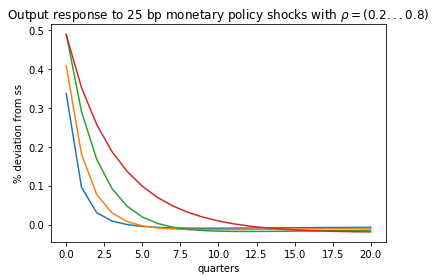

In [32]:
rhos = np.array([0.2, 0.4, 0.6, 0.8])
drstar = -0.0025 * rhos ** (np.arange(T)[:, np.newaxis])
dY = 100 * G['Y']['rstar'] @ drstar

plt.plot(dY[:21])
plt.title(r'Output response to 25 bp monetary policy shocks with $\rho=(0.2 ... 0.8)$')
plt.xlabel('quarters')
plt.ylabel('% deviation from ss')
plt.show()

## Nonlinear impulse responses

Let's compute the nonlinear impulse response for the $\rho=0.6$ shock above. (Don't forget to use the saved Jacobian!)

In [38]:
td_nonlin = two_asset_model.solve_impulse_nonlinear(ss, {"rstar": drstar[:, 2]},
                                                    unknowns, targets, Js={'household': J_ha})

On iteration 0
   max error for asset_mkt is 4.22E-06
   max error for fisher is 2.50E-03
   max error for wnkpc is 5.08E-08
On iteration 1
   max error for asset_mkt is 2.17E-05
   max error for fisher is 1.56E-06
   max error for wnkpc is 1.97E-05
On iteration 2
   max error for asset_mkt is 1.16E-07
   max error for fisher is 3.00E-08
   max error for wnkpc is 8.55E-08
On iteration 3
   max error for asset_mkt is 1.13E-09
   max error for fisher is 6.92E-11
   max error for wnkpc is 5.40E-10


We see rapid convergence and mild nonlinearities in the solution.

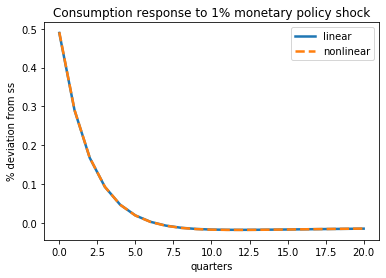

In [39]:
dY_nonlin = 100 * td_nonlin.deviations()["Y"]

plt.plot(dY[:21, 2], label='linear', linestyle='-', linewidth=2.5)
plt.plot(dY_nonlin[:21], label='nonlinear', linestyle='--', linewidth=2.5)
plt.title(r'Consumption response to 1% monetary policy shock')
plt.xlabel('quarters')
plt.ylabel('% deviation from ss')
plt.legend()
plt.show()

Alternatively, we can compute the impulse response to a version of the shock scaled down to 10% of its original size.

In [20]:
td_nonlin = two_asset_model.solve_impulse_nonlinear(ss, {"rstar": 0.1 * drstar[:, 2]},
                                                    unknowns, targets, Js={'household': J_ha})

On iteration 0
   max error for asset_mkt is 4.22E-06
   max error for fisher is 2.50E-04
   max error for wnkpc is 5.08E-08
On iteration 1
   max error for asset_mkt is 2.06E-06
   max error for fisher is 1.71E-08
   max error for wnkpc is 2.09E-06
On iteration 2
   max error for asset_mkt is 6.73E-09
   max error for fisher is 2.65E-10
   max error for wnkpc is 7.61E-09


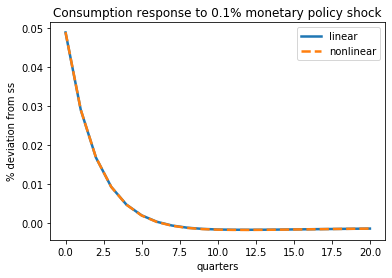

In [21]:
dY_nonlin = 100 * td_nonlin.deviations()["Y"]

plt.plot(0.1*dY[:21, 2], label='linear', linestyle='-', linewidth=2.5)
plt.plot(dY_nonlin[:21], label='nonlinear', linestyle='--', linewidth=2.5)
plt.title(r'Consumption response to 0.1% monetary policy shock')
plt.xlabel('quarters')
plt.ylabel('% deviation from ss')
plt.legend()
plt.show()

When the shock is this small, the linear and nonlinear impulse responses agree exactly. This is a good check, amid a highly complex model, that we didn't make any mistakes.